# Project: an interpretable VAE to study Transcription Factor rewiring
David

## Introduction

Contact: Carl Herrmann, Daria Doncevic (Heidelberg University carl.herrmann@bioquant.uni-heidelberg.de daria.doncevic@bioquant.uni-heidelberg.de)

Variational Autoencoders are now widely applied to capture the complexity in single-cell omics datasets and can be used to replace complete workflows of data analysis consisting of normalization, clustering, celltype annotation and differential expression analysis. However, due to their non-linear nature, they lack interpretability. As you have learned in week 2 of the course, a subset of VAE models such as the VEGA model ([Seninge *et al* (2021)](https://www.nature.com/articles/s41467-021-26017-0)) can convey intrinsic interpretability by incorporating biological networks directly into their model structure. In VEGA, every node in the latent space corresponds to a biological entity such as a pathway or transcription factor (TF) and is then connected only to the genes in the reconstruction layer that are annotated to that biological entity, making the one-layered decoder sparse. Thus, the activations of the nodes in the latent space can be interpreted as pathway or TF activities. In this project, you are going to focus more on the weights of the decoder connections than on the latent space activities, and see how they differ for different genes for a given TF. We believe that this change in the weights between TF and target genes might indicate a rewiring of the TF in different biological condition.
You are also going to estimate uncertainties for the weights (which also depends on the annotation that is used) and to investigate how the weights change in condition versus control, which we call "Transcription factor rewiring".

## Goal
The goal of this project is to study Transcription factor rewiring in the context of interferon response. Thus, you should focus especially on TFs that are known to play a role in interferon response, such as STAT1, STAT2, and the different IRFs, and their target genes. You can read more about that [in this review](https://www.nature.com/articles/nri3787). To be able to obtain different weights for condition and control, you will have to train two separate models. Since VAEs are probabilistic, you will end up with a different set of weights each time you train the model. Thus, your task will also be to estimate or compute uncertainties for the weights. There are different ways to achieve this:


*   Train each model multiple times (and then compute metrics such as mean and standard deviation for the different weights). Are there genes whose annotation to a given TF seems to be "less certain" than for others?
*   When we train multiple models and then aggregate their results, we also call this an ensemble. Training an ensemble is often expensive in terms of computational time and power. Stochastic Weight Averaging (SWA) has been proposed as a method that can yield more robust weights without the need of training ensembles. The publication is linked [here](https://arxiv.org/pdf/1803.05407), and additional information can be found [here](https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/). Try to implement this approach for your VEGA model.
*   Bayesian Neural Networks do built-in estimation of weight uncertainties. Try to replace your linear layer with a Bayesian layer to obtain these estimates. You can find some information to get you started [in this blogpost](https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825/). More mathematical foundations can also be found [here](https://www.cs.toronto.edu/~duvenaud/distill_bayes_net/public/).

In [1]:
#!python -m ipykernel install --user --name=colab-env --display-name="Colab Env"

Do not forget to also include some biological speculation/interpretation of your results!

## Data and model

As in week 2, you will use a dataset that contains peripheral blood mononuclear cells (PBMCs) from systemic lupus patients, treated with Interferon beta or untreated (control). You can follow the steps from week 2's notebook to download the data. You will also work with a VEGA-like model, and you can reuse code from week 2 for the implementation.

This time, instead of Reactome pathways, you will use TF regulons from the collecTRI database as a biological prior. Information about this resource and how to obtain the data is available [here](https://github.com/saezlab/CollecTRI). You might want to filter the regulons based on regulon size prior to incorporation into the model.

## Getting Data

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1050


### scRNAseq data

In [3]:
# download the data
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG' -O PBMC_train.h5ad
#import gdown
#
## Google Drive file ID
#file_id = "1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG"
#url = f"https://drive.google.com/uc?id={file_id}"
#
## Output file name
#output = "PBMC_train.h5ad"
#gdown.download(url, output, quiet=False)


In [4]:
import scanpy as sc

# load data as anndata object
pbmc = sc.read_h5ad("PBMC_train.h5ad")
pbmc

AnnData object with n_obs × n_vars = 13515 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [5]:
pbmc.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 4430719 stored elements and shape (13515, 6998)>

In [6]:
pbmc.obs

,condition,n_counts,n_genes,mt_frac,cell_type
index,,,,,
AAATTCGACATGAC-1-control,control,2275.0,928,0.0,CD8T
TCAGTTACCTCCCA-1-control,control,1422.0,547,0.0,CD8T
GTAGTGTGTTCGTT-1-control,control,1176.0,505,0.0,CD8T
TAACACCTGTCATG-1-control,control,1113.0,514,0.0,CD8T
CAAGAAGACACTGA-1-control,control,2052.0,851,0.0,CD8T
...,...,...,...,...,...
GATCTTTGCTGTCC-1-stimulated,stimulated,1842.0,660,0.0,CD14+Mono
ATATACGATTTGCT-1-stimulated,stimulated,3266.0,1066,0.0,CD14+Mono
GAGGGATGGTCACA-1-stimulated,stimulated,3185.0,725,0.0,CD14+Mono


In [7]:
pbmc.var

,gene_symbol,n_cells
index,,
AL627309.1,AL627309.1,8
RP11-206L10.9,RP11-206L10.9,11
LINC00115,LINC00115,118
NOC2L,NOC2L,1930
KLHL17,KLHL17,28
...,...,...
SLC19A1,SLC19A1,81
COL6A2,COL6A2,51
FTCD,FTCD,5


In [8]:
print(pbmc.X.toarray())
print(f"Shape(observations x genes): {pbmc.X.toarray().shape}")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape(observations x genes): (13515, 6998)


In [9]:
pbmc.shape

(13515, 6998)

### Regulon data

In [10]:
#!pip uninstall -y decoupler
#!pip install decoupler

In [11]:
# processed regulons
import decoupler as dc
regulons = dc.op.collectri(organism='human')
regulons

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


In [12]:
# Check for any TF names starting with "TFII" in the regulons DataFrame
tfii_tfs = regulons[regulons['source'].str.startswith('GTF', na=False)]['source'].unique()
print("Found TFs starting with 'TFII':")
for tf in tfii_tfs:
    print(tf)

Found TFs starting with 'TFII':
GTF2A1
GTF2I
GTF2IRD1
GTF3A
GTF2B
GTF2F1


choose regulons

In [13]:
# prompt: filter regulons dataframe where source equal to something in a list like ["STAT1","STAT2"]

filtered_regulons = regulons[regulons['source'].isin(
    [
      "GTF2I",
      "GTF3A",
      "NRF1",
      "ELF1",
      "STAT1",
      "STAT2",
      "IRF9",
      "STAT3",
      "STAT4",
      "STAT5A",
      "STAT5B",
      "IRF3",
      "IRF7",
      "IRF1",
      "IRF5",
      "IRF8",
     ])]
# source for regulons is https://www.nature.com/articles/nri3787
# I also checked every regulon in this list exists in our dataset
filtered_regulons

,source,target,weight,resources,references,sign_decision
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
5,STAT5B,IL2,1.0,ExTRI,10022878,regulon
15,STAT1,CDKN1A,1.0,ExTRI;TFactS;TRRUST,10023678;10866323;11162600;12239594;16449678;2...,PMID
16,STAT3,CDKN1A,1.0,ExTRI;NTNU.Curated;TRRUST,10023678;11114718;11773079;12438313;15063116;1...,PMID
42,STAT4,IL12B,1.0,ExTRI,10037767;12893768,default activation
...,...,...,...,...,...,...
41490,IRF1,hsa-miR-342,1.0,ExTRI,19151778,default activation
41491,IRF9,hsa-miR-342,1.0,ExTRI,19151778,default activation
41503,STAT1,hsa-miR-221-3p,1.0,ExTRI,20110463,default activation
41506,STAT3,hsa-miR-21,1.0,ExTRI,20813833;21685938;22210182;23416424,regulon


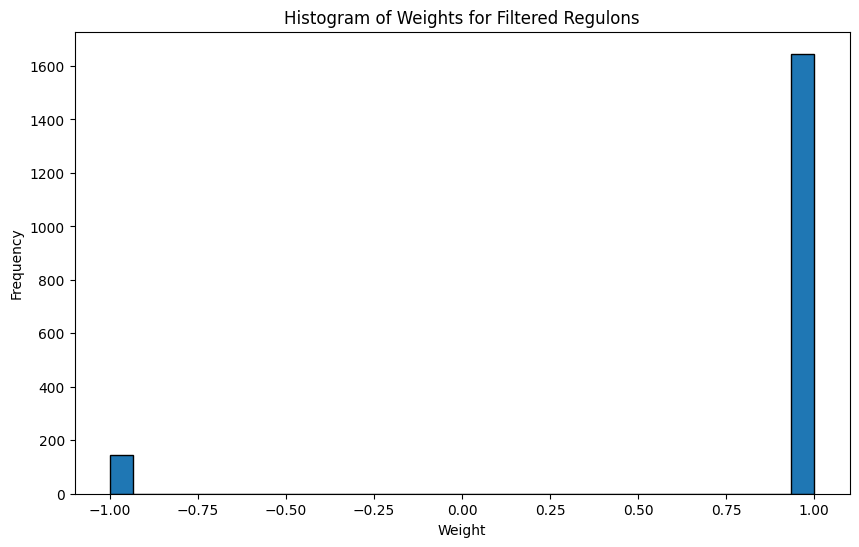

In [14]:
# prompt: create an histogram for dataframe filtered_regulons, column weight

import matplotlib.pyplot as plt

# Assuming 'filtered_regulons' DataFrame and 'weight' column exist
plt.figure(figsize=(10, 6))
plt.hist(filtered_regulons['weight'], bins=30, edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Histogram of Weights for Filtered Regulons')
plt.show()

filter regulons for size, for this, create a histogram for how counts of our chosen regulons in dataframe

source
STAT3     437
STAT1     305
STAT5A    215
IRF1      170
STAT5B    106
NRF1       91
IRF3       83
ELF1       80
IRF8       69
STAT2      50
IRF5       37
IRF7       34
STAT4      32
IRF9       29
GTF3A      28
GTF2I      23
Name: count, dtype: int64


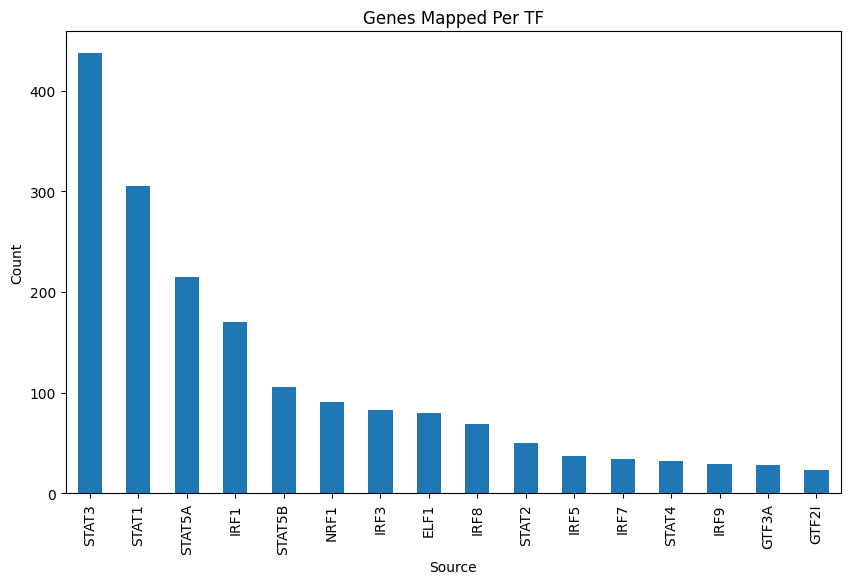

In [15]:
print(filtered_regulons['source'].value_counts())
# prompt: create a histogram for counts of each unique values in source column
# Assuming 'filtered_regulons' DataFrame and 'source' column exist
plt.figure(figsize=(10, 6))
filtered_regulons['source'].value_counts().plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Genes Mapped Per TF')
plt.show()

## Create Mask

this function was copied from exercise, but we do not have a .gmt file

.gmt file format is like this for each line: name, link, gene1, gene2, ...

but we have a dataframe of columns: source(TF), target(gene), weight(-1 or 1)

I believe we should mark -1 in mask if the weight is -1, unlike the previous implementation

Writing our own function / creating our own mask
- convert to polars because i'm more familiar with it
- keep only the gene names in the anndata object, so we wont keep genenames without corresponding data in the mask
- convert the df from long to wide format, values will be weights, columns will be TFs, gene names will stay in rows
-

In [16]:
pbmc.var.index.to_numpy()

array(['AL627309.1', 'RP11-206L10.9', 'LINC00115', ..., 'FTCD', 'DIP2A',
       'S100B'], shape=(6998,), dtype=object)

In [17]:

import polars as pl

extra_nodes_count = 2

# rows should correspond to genes
# cols should correspond to gene sets/TFs
def create_mask(pbmc_tmp):
  tmp = (
    pl
    .from_pandas(filtered_regulons)
    # alice and kerem and yusuf decided to convert all -1 to 1 and remove positive weights restriction
    .with_columns(
        pl.col("weight").replace(-1,1)
    )
    .filter(
        pl.col("target").is_in(pbmc_tmp.var.index.to_numpy())
    ) # 901 x 13 -> 332 x 13
    .pivot(
        on = "source", # new columns
        index = "target", # stays in rows
        values = "weight"
    )
    .fill_null(0)
  )

  for i in range(0,extra_nodes_count):
    node_index = i + 1
    node_name = "unannotated_" + str(node_index)
    tmp = tmp.with_columns(
        pl.lit(1).alias(node_name)
    )

    return tmp

mask_polars_df = create_mask(pbmc)
mask_polars_df


target,STAT5A,STAT5B,STAT4,IRF1,STAT3,GTF2I,STAT1,IRF8,NRF1,ELF1,IRF3,IRF5,STAT2,IRF7,IRF9,GTF3A,unannotated_1
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""IL2""",1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"""IRF1""",1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
"""CCND1""",1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"""PRF1""",1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"""IFNG""",1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ZC3HAV1""",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"""ZNF181""",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"""ZNF230""",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


The exercise also adds fully connected nodes (default 1) to the mask as extra nodes, I am not sure if we want to still do that. and if we are gonna do that, we should create them in pairs as our mask values can be -1 too.

We need to add mask and the TF information to the anndata object

In [18]:
pbmc.uns['_vega'] = dict() #create attribute "_vega" to store the mask and pathway information
pbmc.uns['_vega']['mask'] = mask_polars_df
pbmc.uns['_vega']['gmv_names'] = mask_polars_df.drop("target").columns

pbmc.uns['_vega']

{'mask': shape: (378, 18)
 ┌─────────┬────────┬────────┬───────┬───┬──────┬──────┬───────┬───────────────┐
 │ target  ┆ STAT5A ┆ STAT5B ┆ STAT4 ┆ … ┆ IRF7 ┆ IRF9 ┆ GTF3A ┆ unannotated_1 │
 │ ---     ┆ ---    ┆ ---    ┆ ---   ┆   ┆ ---  ┆ ---  ┆ ---   ┆ ---           │
 │ str     ┆ f64    ┆ f64    ┆ f64   ┆   ┆ f64  ┆ f64  ┆ f64   ┆ i32           │
 ╞═════════╪════════╪════════╪═══════╪═══╪══════╪══════╪═══════╪═══════════════╡
 │ IL2     ┆ 1.0    ┆ 1.0    ┆ 0.0   ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0   ┆ 1             │
 │ IRF1    ┆ 1.0    ┆ 1.0    ┆ 1.0   ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0   ┆ 1             │
 │ CCND1   ┆ 1.0    ┆ 1.0    ┆ 0.0   ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0   ┆ 1             │
 │ PRF1    ┆ 1.0    ┆ 1.0    ┆ 1.0   ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0   ┆ 1             │
 │ IFNG    ┆ 1.0    ┆ 1.0    ┆ 1.0   ┆ … ┆ 0.0  ┆ 1.0  ┆ 0.0   ┆ 1             │
 │ …       ┆ …      ┆ …      ┆ …     ┆ … ┆ …    ┆ …    ┆ …     ┆ …             │
 │ ZC3HAV1 ┆ 0.0    ┆ 0.0    ┆ 0.0   ┆ … ┆ 0.0  ┆ 0.0  ┆ 0.0   ┆ 1             │
 │

In [19]:
mask_np = mask_polars_df.drop("target").to_numpy()

In [20]:
#filtering genes for in mask
pmbc_genes_subset = pbmc[:, mask_polars_df["target"].to_list()].copy()
pmbc_genes_subset

AnnData object with n_obs × n_vars = 13515 × 378
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors', '_vega'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

## Build the Sparse VAE

In [21]:
import torch; torch.manual_seed(100)
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import math
import numpy as np
np.random.seed(100)
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import scanpy as sc
from collections import OrderedDict
from collections import Counter

# select the right device, depending on whether your Colab runs on GPU or CPU
### IMPORTANT: we recommend to change your runtime to GPU, otherwise the training takes much longer
device = 'cuda'

torch.cuda.is_available()

True

In [22]:
# Bayesian Sparce Layer
# This is a custom layer that implements a Bayesian sparse layer. somewhere in the end

# only change was in positive_weights function, we no longer restrict the weights
class VEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3, clamp_mu = False):
        super(VEGA, self).__init__()

        self.clamp_mu = clamp_mu # if True, we clamp the mu to be positive

        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = DecoderVEGA(mask)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout, z_dropout): #dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout))  #two layer, fully connected encoder with dropout


        self.mu = nn.Sequential(nn.Linear(800, latent_dims),
                                nn.Dropout(p = z_dropout))

        self.sigma = nn.Sequential(nn.Linear(800, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        mu =  self.mu(x)
        sigma = torch.exp(self.sigma(x)) # 7/03/2025: THERE WAS A TYPO HERE!!
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z
    
    def clamp_mu(self):
        """
        Clamp mu to be positive
        """
        if self.clamp_mu:
            with torch.no_grad():
                self.mu[0].weight.clamp_(min=0)  # clamp the mu weights to be positive


class DecoderVEGA(nn.Module):
    def __init__(self, mask):
        super(DecoderVEGA, self).__init__()
        self.sparse_layer = BayesianSparseLayer(mask)

    def forward(self, x):
        return self.sparse_layer(x.to(device))

    def weights(self):
        w = self.sparse_layer.weight_mu * self.sparse_layer.mask
        return w

    def kl(self):
        return self.sparse_layer.kl
    




######### You don't need to understand this part of the code in detail #########
class SparseLayerFunction(torch.autograd.Function):
    """
    We define our own autograd function which masks it's weights by 'mask'.
    For more details, see https://pytorch.org/docs/stable/notes/extending.html
    """

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask):

        weight = weight * mask # change weight to 0 where mask == 0
        #calculate the output
        output = input.mm(weight.t())
        output += bias.unsqueeze(0).expand_as(output) # Add bias to all values in output
        ctx.save_for_backward(input, weight, bias, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output): # define the gradient formula
        input, weight, bias, mask = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = grad_mask = None

        # These needs_input_grad checks are optional and only to improve efficiency
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
            # change grad_weight to 0 where mask == 0
            grad_weight = grad_weight * mask
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, grad_mask


class BayesianSparseLayer(nn.Module):
    def __init__(self, mask, prior_std=1.0):
        """
        Bayesian sparse layer: weights are sampled from a Gaussian.
        Mask determines the sparse connections.
        """
        super(BayesianSparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)

        # Learnable mean and log std of weights
        self.weight_mu = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0]))
        self.weight_logvar = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0]))

        self.bias = nn.Parameter(torch.Tensor(mask.shape[1]))
        self.reset_parameters()

        self.prior_std = prior_std  # used for KL divergence

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight_mu.size(1))
        self.weight_mu.data.uniform_(-stdv, stdv)
        self.weight_logvar.data.fill_(-5.0)  # small initial variance
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        # Sample weights from posterior
        std = torch.exp(0.5 * self.weight_logvar)
        eps = torch.randn_like(std)
        weight_sample = self.weight_mu + eps * std

        # Apply mask
        weight_sample = weight_sample * self.mask

        # Linear forward pass
        output = input.mm(weight_sample.t()) + self.bias

        # Store KL divergence for the layer
        self.kl = self.kl_divergence()
        return output

    def kl_divergence(self):
        """
        KL divergence between posterior and prior N(0, prior_std^2)
        """
        std = torch.exp(0.5 * self.weight_logvar)
        var = std ** 2
        prior_var = self.prior_std ** 2

        kl = 0.5 * ((var + self.weight_mu ** 2) / prior_var - 1 - self.weight_logvar + math.log(prior_var))
        kl = kl * self.mask  # Only count masked weights
        return kl.sum()


In [23]:
# Training loop for BAYESIAN VEGA
def trainVEGA(vae, data, epochs=60, beta=0.0001, learning_rate=0.001):
    opt = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=5e-4)
    vae.train()
    losses, klds, mses = [], [], []

    for epoch in range(epochs):
        loss_e = kld_e = mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()

            # Total KL divergence = encoder + decoder
            kld_encoder = vae.encoder.kl
            kld_decoder = vae.decoder.kl()
            kld = beta * (kld_encoder + kld_decoder)

            loss = mse + kld
            loss.backward()
            opt.step()

            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()

            vae.encoder.clamp_mu()


        losses.append(loss_e / (len(data)*128))
        klds.append(kld_e / (len(data)*128))
        mses.append(mse_e / (len(data)*128))

        print("epoch:", epoch, " loss:", loss_e / (len(data)*128))

    return vae, losses, klds, mses


In [24]:
pbmcX = torch.utils.data.DataLoader(pmbc_genes_subset.X.toarray(), batch_size=128) #set up the training data in the right format

In [25]:
pmbc_control=pmbc_genes_subset[pmbc_genes_subset.obs["condition"] == "control"]
pmbc_stimulated=pmbc_genes_subset[pmbc_genes_subset.obs["condition"] == "stimulated"]
pmbcX_ctrl = torch.utils.data.DataLoader(pmbc_control.X.toarray(), batch_size=128) #set up the training data in the right formatpbmcX = torch.utils.data.DataLoader(pmbc_genes_subset.X.toarray(), batch_size=128) #set up the training data in the right format
pmbcX_stim = torch.utils.data.DataLoader(pmbc_stimulated.X.toarray(), batch_size=128) #set up the training data in the right format

In [43]:
vega = VEGA(latent_dims= mask_np.shape[1], input_dims = mask_np.shape[0], mask = mask_np.T, z_dropout = 0.5, dropout = 0.3, clamp_mu=True).to(device)
# model training    
#vega, vega_losses, vega_klds, vega_mses = trainVEGA(vega, pmbcX_ctrl, epochs = 100, beta = 0.0001) 
vega, vega_losses, vega_klds, vega_mses = trainVEGA(vega, pmbcX_stim, epochs = 100, beta = 0.0001) 

epoch: 0  loss: 121.16423
epoch: 1  loss: 107.85315
epoch: 2  loss: 98.467674
epoch: 3  loss: 90.633316
epoch: 4  loss: 81.58311
epoch: 5  loss: 73.85034
epoch: 6  loss: 69.28791
epoch: 7  loss: 66.459274
epoch: 8  loss: 64.496284
epoch: 9  loss: 62.714825
epoch: 10  loss: 61.052654
epoch: 11  loss: 59.961792
epoch: 12  loss: 58.93694
epoch: 13  loss: 57.8873
epoch: 14  loss: 59.133587
epoch: 15  loss: 56.261288
epoch: 16  loss: 55.14727
epoch: 17  loss: 57.38293
epoch: 18  loss: 55.174126
epoch: 19  loss: 53.41709
epoch: 20  loss: 53.8948
epoch: 21  loss: 53.097767
epoch: 22  loss: 51.153767
epoch: 23  loss: 50.693928
epoch: 24  loss: 49.99546
epoch: 25  loss: 49.572693
epoch: 26  loss: 49.310116
epoch: 27  loss: 49.485584
epoch: 28  loss: 49.37741
epoch: 29  loss: 48.357964
epoch: 30  loss: 47.82671
epoch: 31  loss: 47.227352
epoch: 32  loss: 46.78533
epoch: 33  loss: 46.50412
epoch: 34  loss: 46.212273
epoch: 35  loss: 46.064358
epoch: 36  loss: 46.082092
epoch: 37  loss: 45.29409
e

In [27]:
#vega.decoder.sparse_layer[0].weight.count_nonzero()

#this is for Bayesian
(vega.decoder.sparse_layer.weight_mu.abs() > 1e-5).sum()




tensor(1068, device='cuda:0')

In [44]:
#Bayesian data extraction
# -> Trebalo bi sve jako niske MU vrijednosti zamjeniti nulom kada budemo kasnije radili usporedbu, 
#   ...hm ali  je li to ispravno? Uz to DEFINTIIVNO treba sve STD od tih malih MU smanjit na 0 jer ovako je beskorisno
# Get the Bayesian layer
bayesian_layer = vega.decoder.sparse_layer

# Get current parameters
weight_mu = bayesian_layer.weight_mu.data
weight_logvar = bayesian_layer.weight_logvar.data

# Convert logvar to std
weight_std = torch.exp(0.5 * weight_logvar)

# Create mask for small absolute mu values
mask = weight_mu.abs() < 1e-7

# Apply mask: zero out corresponding mus and logvars
weight_mu[mask] = 0.0
weight_logvar[mask] = -float('inf')  # ln(std^2) = -inf --> std = 0 

# Optionally, recompute std after masking
weight_std = torch.exp(0.5 * weight_logvar)


In [45]:
weight_std

tensor([[0.0262, 0.0269, 0.0000,  ..., 0.0000, 0.0000, 0.0303],
        [0.0299, 0.0300, 0.0290,  ..., 0.0000, 0.0000, 0.0330],
        [0.0290, 0.0262, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0296],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0300]],
       device='cuda:0')

In [46]:
import pandas as pd

# Assuming you already have:
# weight_mu (Tensor) — shape: [n_outputs, n_latents]
# weight_std (Tensor) — same shape

n_outputs, n_latents = weight_mu.shape

# Create lists for each column
iteration_list = []
tf_list = []
gene_list = []
wei_list = []
std_list = []
cond_list = []

for tf_idx in range(n_latents):
    for gene_idx in range(n_outputs):
        iteration_list.append(0)
        tf_list.append(f"TF_{tf_idx}")
        gene_list.append(f"Gene_{gene_idx}")
        wei_list.append(weight_mu[gene_idx, tf_idx].item())
        std_list.append(weight_std[gene_idx, tf_idx].item())
        #cond_list.append("control")
        cond_list.append("stimulated")

# Create the DataFrame
df = pd.DataFrame({
    'iteration': iteration_list,
    'tf': tf_list,
    'gene': gene_list,
    'wei': wei_list,
    'STD': std_list,
    'cond': cond_list
})
# Save to CSV
#df.to_csv("weights_bayesian_control.csv", index=False)
df.to_csv("weights_bayesian_stimulated.csv", index=False)

In [31]:
df

,iteration,tf,gene,wei,STD,cond
0,0,TF_0,Gene_0,0.003767,0.028983,control
1,0,TF_0,Gene_1,0.029085,0.032506,control
2,0,TF_0,Gene_2,0.003170,0.031156,control
3,0,TF_0,Gene_3,0.066258,0.031960,control
4,0,TF_0,Gene_4,0.001912,0.029964,control
...,...,...,...,...,...,...
6421,0,TF_16,Gene_373,0.006820,0.026623,control
6422,0,TF_16,Gene_374,0.003257,0.024524,control
6423,0,TF_16,Gene_375,0.009751,0.024830,control
6424,0,TF_16,Gene_376,0.005901,0.025279,control


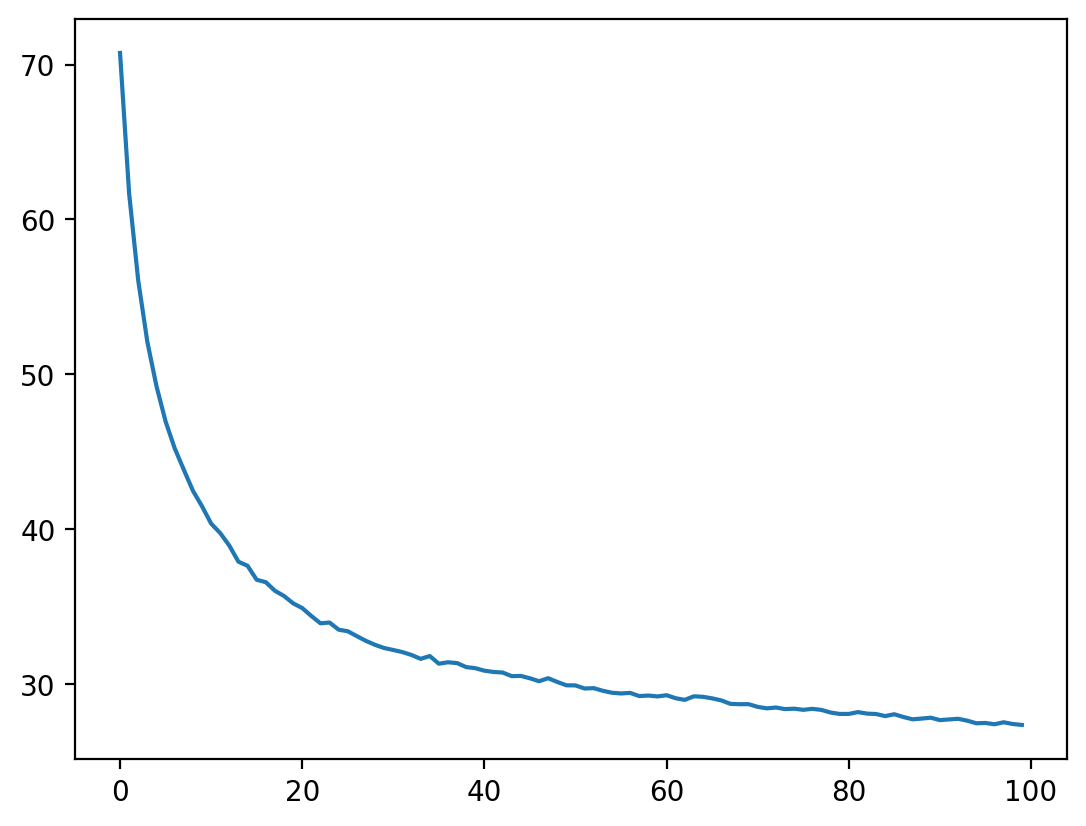

In [32]:
plt.plot(vega_losses)

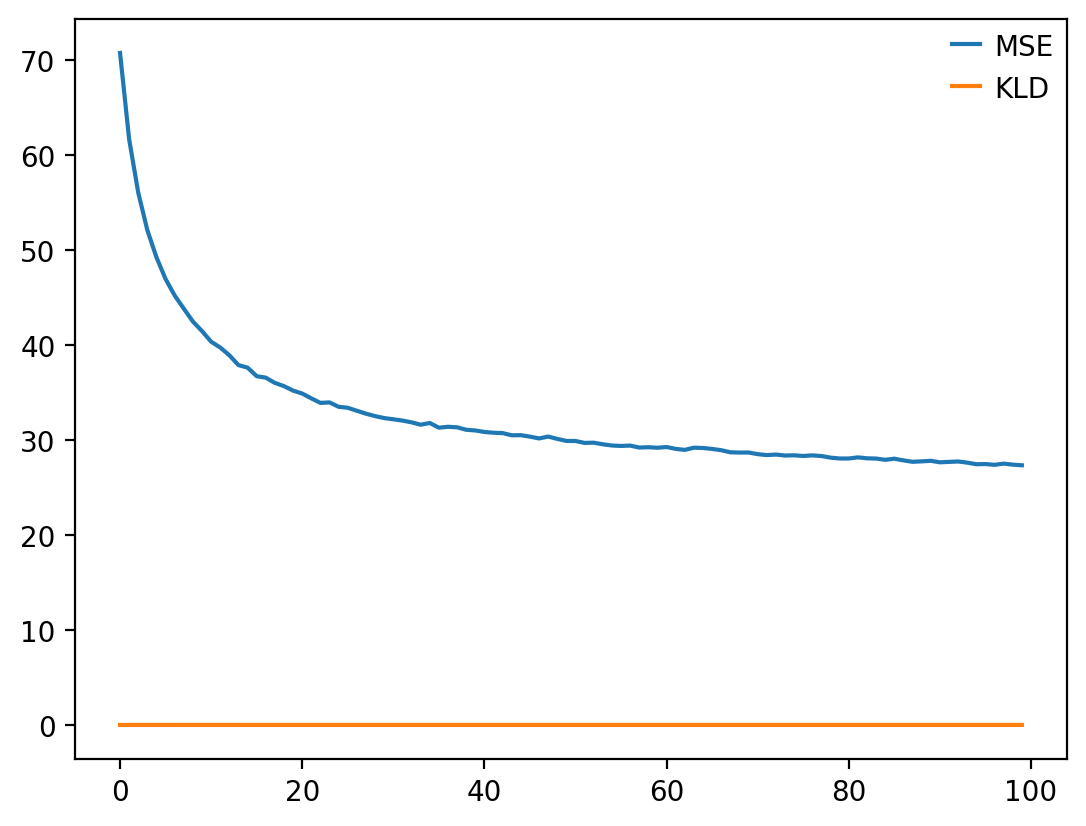

In [33]:
# plot mse and kld
plt.plot(vega_mses, label = "MSE")
plt.plot(vega_klds, label = "KLD")
plt.legend()

In [34]:
def to_latent(vae, adata):
        latent = []
        data = torch.tensor(adata.X.toarray()).to(device)
        vae.eval() # we need to set the model to evaluation mode, so that the dropout is no longer considered
        z = vae.encoder(data)
        latent += [z.to("cpu")]
        return torch.cat(latent).detach().numpy()

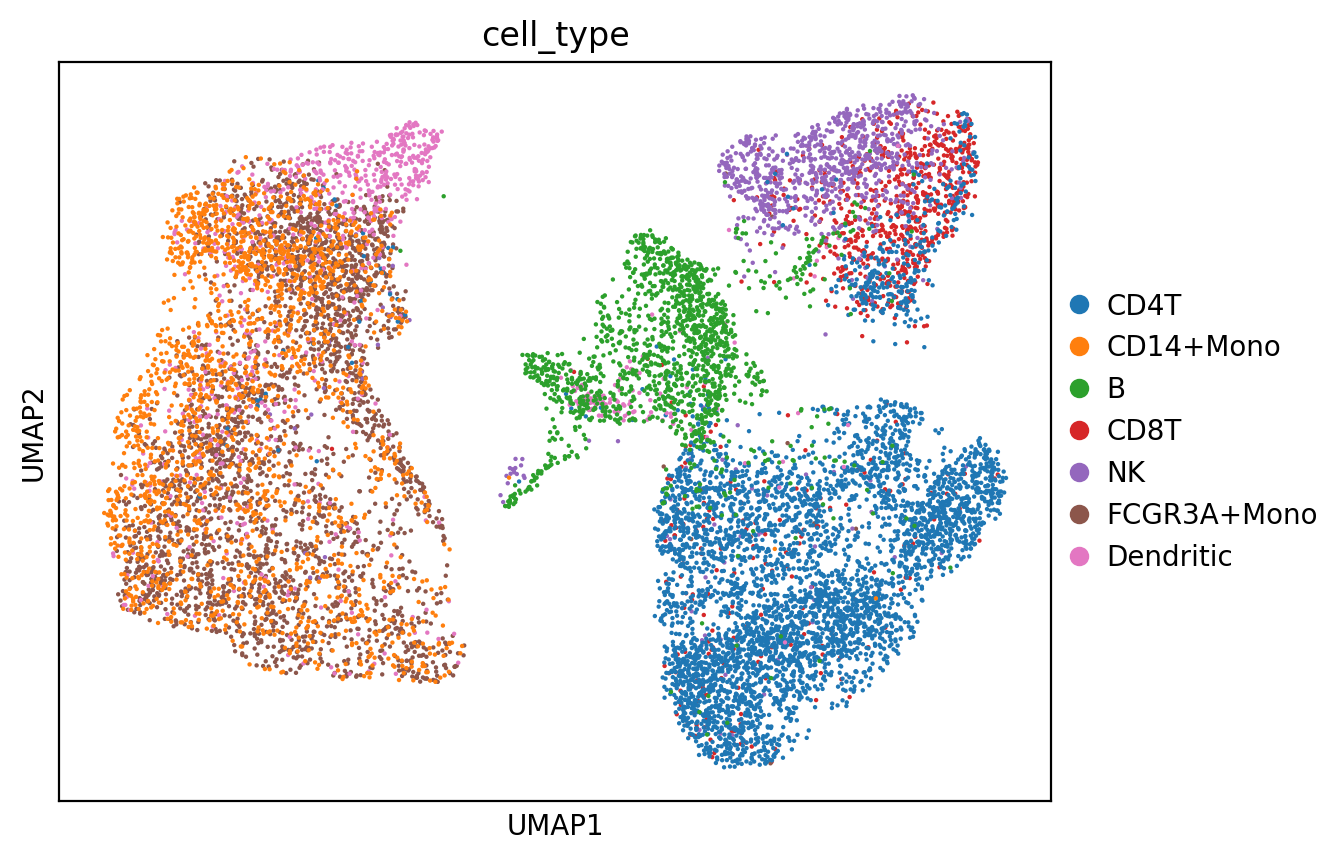

In [35]:
pmbc_genes_subset.obsm["latent_embedding"] = to_latent(vega, pmbc_genes_subset) # project the cells to the model's latent space

# UMAP based on the latent embedding
sc.pp.neighbors(pmbc_genes_subset, use_rep='latent_embedding', n_neighbors=15)

sc.tl.umap(pmbc_genes_subset, random_state=1) #set random state to ensure reproducibility

sc.pl.umap(pmbc_genes_subset, color=["cell_type"], size=10, ncols = 1)

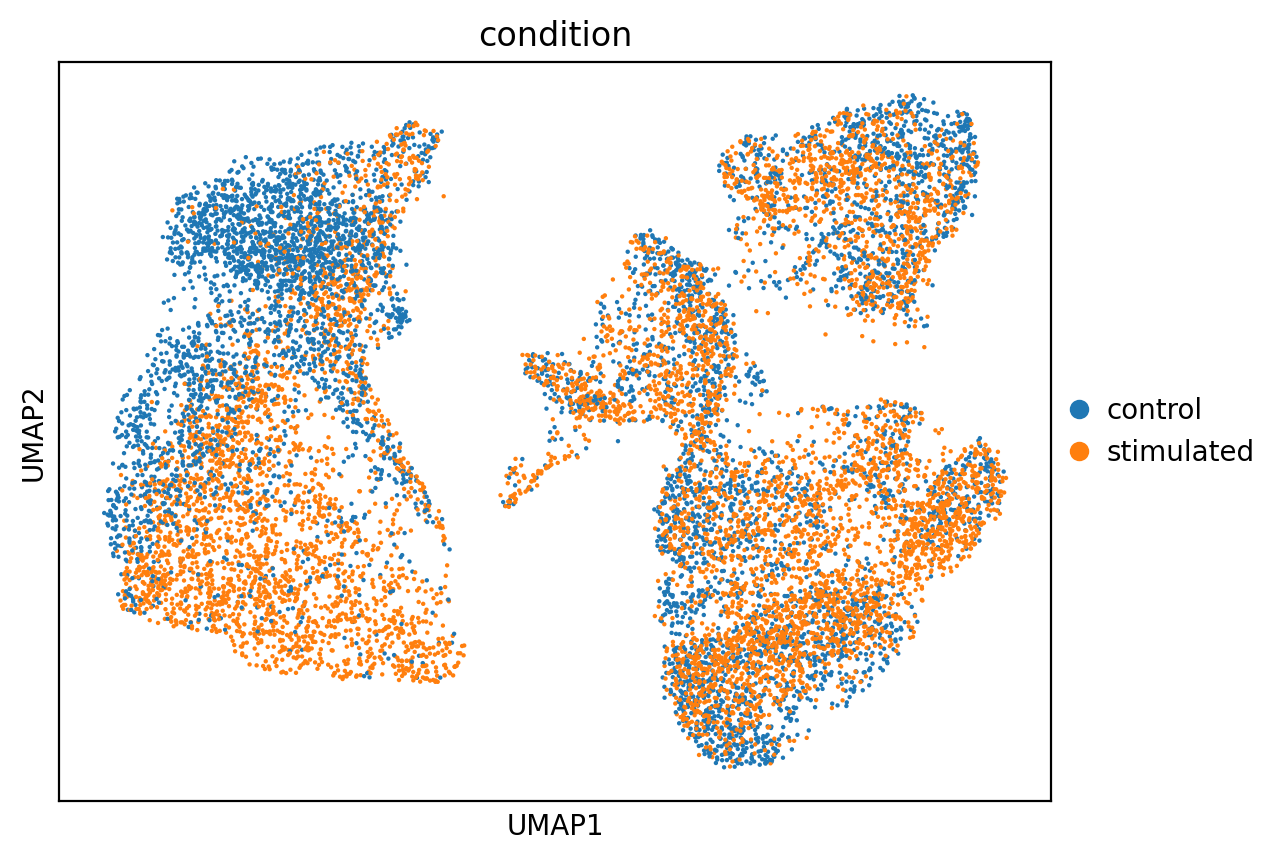

In [36]:
sc.pl.umap(pmbc_genes_subset, color=["condition"], size=10, ncols = 1)

In [38]:
def plot_ranked_gene_weights(model: VEGA, adata,
                        gmv,
                        n_genes: int = 10):
    """
    Plot gene members of input GMVs according to their magnitude.
    """
    w = vega.state_dict()["decoder.sparse_layer.0.weight"].to("cpu")
    gmv_names = list(adata.uns['_vega']['gmv_names'])
    gene_names = adata.var.index.tolist()


    # Get values
    i = gmv_names.index(gmv)
    w_i = w[:,i].detach().numpy()
    sort_idx = np.argsort(w_i)[::-1]
    sort_w = w_i[sort_idx][:n_genes]
    genes = np.array(gene_names)[sort_idx][:n_genes]

    # Set plot params
    ymin = np.min(sort_w)
    ymax = np.max(sort_w)
    ymax += 0.3*(ymax - ymin)

    # Plot
    for ig, gene_name in enumerate(genes):
        plt.text(
            ig,
            sort_w[ig],
            gene_name,
            rotation='vertical',
            verticalalignment='bottom',
            horizontalalignment='center',
            color="black"
        )
    plt.title(gmv)
    plt.ylim(ymin, ymax)
    plt.xlim(-0.9, n_genes - 0.1)
    plt.xlabel('Ranking')
    plt.ylabel('Weight magnitude')
    plt.xticks(np.arange(0, n_genes, step=1), labels = np.arange(1, n_genes+1, step=1))

    plt.show()

plot_ranked_gene_weights(vega, gmv= "STAT1", adata = pmbc_genes_subset, n_genes = 20)

KeyError: 'decoder.sparse_layer.0.weight'

In [ ]:
import pandas as pd

def Dataframecombined_2(pbmc, trans, rep, nome):
    mask = create_mask(pbmc).drop("target").to_numpy()
    print("mask done")
    # Estrai nome condizione (modifica se la chiave è diversa)
    cond_name = nome

    # Crea DataLoader
    pbmcX = torch.utils.data.DataLoader(pbmc.X.toarray(), batch_size=128)

    # DataFrame finale
    dfs = pd.DataFrame(columns=['iteration', 'tf', 'gene', 'wei', 'cond'])

    for i in range(rep):
        if i % 2 == 0:
            print(f"Iteration: {i}")

        # Inizializza e addestra VEGA
        vega = VEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, z_dropout = 0.5, dropout = 0.3).to(device)
        # model training
        vega, vega_losses, vega_klds, vega_mses = trainVEGA(vega, pbmcX, epochs = 100, beta = 0.0001) #takes about 2 mins on GPU
        pbmc.obsm["latent_embedding"] = to_latent(vega, pbmc) # project the cells to the model's latent space

# UMAP based on the latent embedding
        #sc.pp.neighbors(pbmc, use_rep='latent_embedding', n_neighbors=15)

        #sc.tl.umap(pbmc, random_state=1) #set random state to ensure reproducibility

        #sc.pl.umap(pbmc, color=["cell_type"], size=10, ncols = 1)
        #sc.pl.umap(pbmc, color=["condition"], size=10, ncols = 1)
        # Ottieni pesi
        weights = vega.decoder.weights().detach().cpu().numpy()

        # Assumi che tf_names e gmv_names siano disponibili
        tf_names = pbmc.uns["_vega"]["gmv_names"]
        gene_names = pbmc.var_names

        # Verifica le dimensioni
        assert len(gene_names) == weights.shape[0], "Mismatch tra numero geni e righe dei pesi"
        assert len(tf_names) == weights.shape[1], "Mismatch tra numero TF e colonne dei pesi"

        # Costruzione delle righe
        rows = [
            {
                'iteration': i,
                'tf': tf_names[tf_idx],
                'gene': gene_names[gene_idx],
                'wei': weights[gene_idx][tf_idx],
                'cond': cond_name
            }
            for gene_idx in range(len(gene_names))
            for tf_idx in range(len(tf_names))
        ]

        df = pd.DataFrame(rows)
        dfs = pd.concat([dfs, df], ignore_index=True)

    return dfs

In [ ]:
pmbc_control=pmbc_genes_subset[pmbc_genes_subset.obs["condition"] == "control"]
pmbc_stimulated=pmbc_genes_subset[pmbc_genes_subset.obs["condition"] == "stimulated"]
combined_df_c=Dataframecombined_2(pmbc_control,filtered_regulons, 20, "control")
combined_df_s=Dataframecombined_2(pmbc_stimulated,filtered_regulons, 20, "stimulated")
union=pd.concat([combined_df_c,combined_df_s])
union

mask done
Iteration: 0
epoch:  0  loss:  126.13153
epoch:  1  loss:  108.04469
epoch:  2  loss:  90.30414
epoch:  3  loss:  72.09454
epoch:  4  loss:  64.50162
epoch:  5  loss:  61.773743
epoch:  6  loss:  59.082798
epoch:  7  loss:  57.682465
epoch:  8  loss:  56.856457
epoch:  9  loss:  58.41051
epoch:  10  loss:  56.55604
epoch:  11  loss:  55.428284
epoch:  12  loss:  55.12612
epoch:  13  loss:  53.884834
epoch:  14  loss:  53.53023
epoch:  15  loss:  53.127068
epoch:  16  loss:  52.65452
epoch:  17  loss:  52.59658
epoch:  18  loss:  51.465332
epoch:  19  loss:  51.55675
epoch:  20  loss:  51.230995
epoch:  21  loss:  51.145355
epoch:  22  loss:  50.428555
epoch:  23  loss:  50.118637
epoch:  24  loss:  49.66468
epoch:  25  loss:  49.6521
epoch:  26  loss:  49.3874
epoch:  27  loss:  49.277367
epoch:  28  loss:  48.64233
epoch:  29  loss:  49.134525
epoch:  30  loss:  48.45981
epoch:  31  loss:  47.945694
epoch:  32  loss:  47.807858
epoch:  33  loss:  47.660732
epoch:  34  loss: 

C:\Users\Korisnik\AppData\Local\Temp\ipykernel_17500\424555519.py:23: ImplicitModificationWarning: Setting element `.obsm['latent_embedding']` of view, initializing view as actual.
  pbmc.obsm["latent_embedding"] = to_latent(vega, pbmc) # project the cells to the model's latent space
C:\Users\Korisnik\AppData\Local\Temp\ipykernel_17500\424555519.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat([dfs, df], ignore_index=True)


epoch:  0  loss:  127.004456
epoch:  1  loss:  110.47905
epoch:  2  loss:  95.91574
epoch:  3  loss:  75.671585
epoch:  4  loss:  69.145485
epoch:  5  loss:  65.76921
epoch:  6  loss:  60.088512
epoch:  7  loss:  59.065144
epoch:  8  loss:  58.095802
epoch:  9  loss:  56.678528
epoch:  10  loss:  56.172745
epoch:  11  loss:  55.834175
epoch:  12  loss:  55.20634
epoch:  13  loss:  54.85624
epoch:  14  loss:  54.18656
epoch:  15  loss:  54.061638
epoch:  16  loss:  53.080757
epoch:  17  loss:  52.962013
epoch:  18  loss:  52.762257
epoch:  19  loss:  52.45568
epoch:  20  loss:  51.39799
epoch:  21  loss:  51.73348
epoch:  22  loss:  51.1631
epoch:  23  loss:  51.09649
epoch:  24  loss:  50.437916
epoch:  25  loss:  50.58365
epoch:  26  loss:  50.112198
epoch:  27  loss:  49.930664
epoch:  28  loss:  50.238483
epoch:  29  loss:  49.6137
epoch:  30  loss:  49.269283
epoch:  31  loss:  48.738323
epoch:  32  loss:  48.730682
epoch:  33  loss:  48.274834
epoch:  34  loss:  48.084965
epoch:  

C:\Users\Korisnik\AppData\Local\Temp\ipykernel_17500\424555519.py:23: ImplicitModificationWarning: Setting element `.obsm['latent_embedding']` of view, initializing view as actual.
  pbmc.obsm["latent_embedding"] = to_latent(vega, pbmc) # project the cells to the model's latent space
C:\Users\Korisnik\AppData\Local\Temp\ipykernel_17500\424555519.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat([dfs, df], ignore_index=True)


epoch:  0  loss:  167.13228
epoch:  1  loss:  142.10483
epoch:  2  loss:  118.24308
epoch:  3  loss:  96.04198
epoch:  4  loss:  82.15965
epoch:  5  loss:  78.16406
epoch:  6  loss:  83.15861
epoch:  7  loss:  80.53552
epoch:  8  loss:  74.095604
epoch:  9  loss:  70.930244
epoch:  10  loss:  69.25428
epoch:  11  loss:  68.60564
epoch:  12  loss:  67.69654
epoch:  13  loss:  67.13266
epoch:  14  loss:  66.217064
epoch:  15  loss:  65.81997
epoch:  16  loss:  64.75197
epoch:  17  loss:  64.19205
epoch:  18  loss:  64.101234
epoch:  19  loss:  63.90512
epoch:  20  loss:  62.783405
epoch:  21  loss:  62.332684
epoch:  22  loss:  61.69829
epoch:  23  loss:  61.43119
epoch:  24  loss:  60.626183
epoch:  25  loss:  59.97653
epoch:  26  loss:  59.754448
epoch:  27  loss:  59.846096
epoch:  28  loss:  59.340126
epoch:  29  loss:  58.37793
epoch:  30  loss:  59.56599
epoch:  31  loss:  59.31579
epoch:  32  loss:  57.19098
epoch:  33  loss:  56.630596
epoch:  34  loss:  56.639275
epoch:  35  los

,iteration,tf,gene,wei,cond
0,0,ELF1,ANGPT2,0.000144,control
1,0,IRF1,ANGPT2,-0.000000,control
2,0,IRF3,ANGPT2,0.000000,control
3,0,IRF5,ANGPT2,0.000000,control
4,0,IRF7,ANGPT2,0.000000,control
...,...,...,...,...,...
220795,19,STAT3,RASD1,-0.000000,stimulated
220796,19,STAT4,RASD1,-0.000000,stimulated
220797,19,STAT5A,RASD1,0.000000,stimulated
220798,19,STAT5B,RASD1,-0.000230,stimulated


ValueError: cannot reindex on an axis with duplicate labels

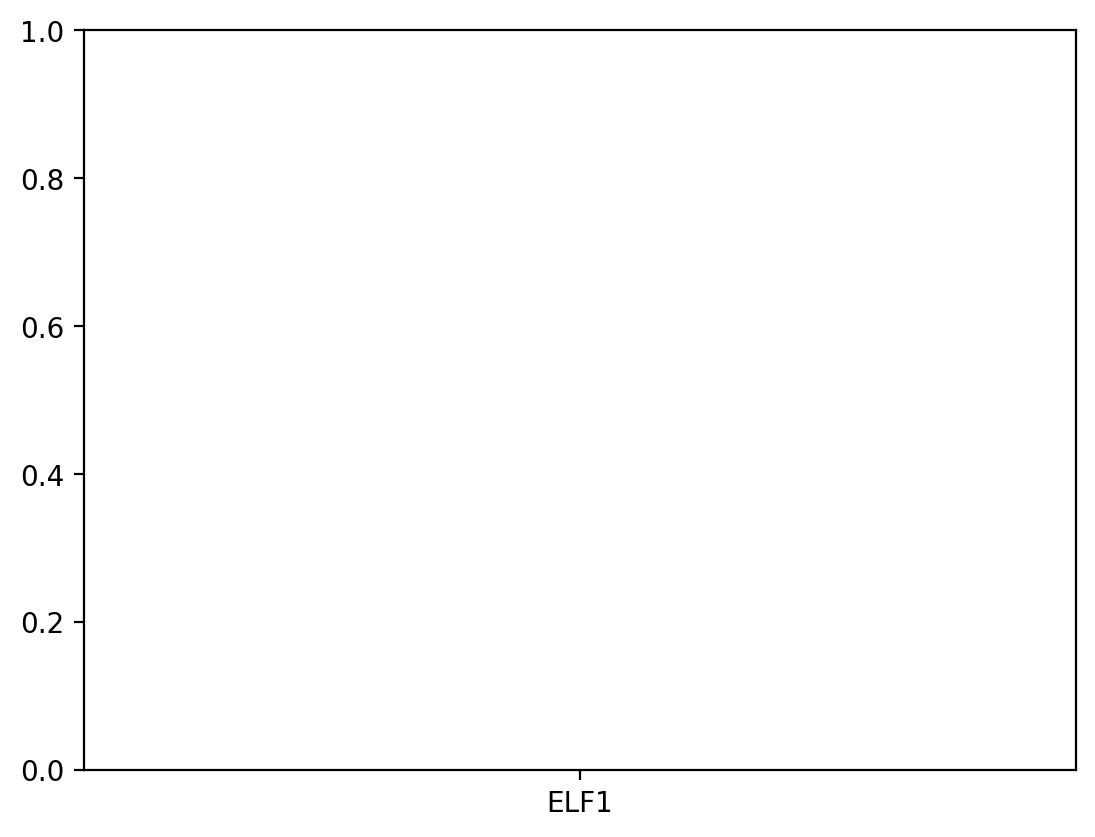

In [ ]:
import seaborn as sns
sns.boxplot(union, x="tf", y="wei", hue="cond")

In [ ]:
pl.from_pandas(union).write_csv("vega_weights.csv", separator="\t")

In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv("vega_weights.csv", sep="\t")

# Basic info about the dataframe
print("DataFrame Info:")
print(df.info())
print("\nNull values in each column:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

# Check for infinite values
print("\nInfinite values in each column:")
print(np.isinf(df.select_dtypes(include=np.number)).sum())

# Display first few rows
print("\nFirst few rows of the data:")
print(df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441600 entries, 0 to 441599
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   iteration  441600 non-null  int64  
 1   tf         441600 non-null  object 
 2   gene       441600 non-null  object 
 3   wei        430560 non-null  float64
 4   cond       441600 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 16.8+ MB
None

Null values in each column:
iteration        0
tf               0
gene             0
wei          11040
cond             0
dtype: int64

Basic statistics:
           iteration            wei
count  441600.000000  430560.000000
mean        9.500000       0.000006
std         5.766288       0.006714
min         0.000000      -0.224423
25%         4.750000      -0.000000
50%         9.500000       0.000000
75%        14.250000       0.000000
max        19.000000       0.191463

Infinite values in each column:
iterat

In [ ]:
df[df['wei'].isnull()].head()

,iteration,tf,gene,wei,cond
397440,16,ELF1,ANGPT2,NaN,stimulated
397441,16,IRF1,ANGPT2,NaN,stimulated
397442,16,IRF3,ANGPT2,NaN,stimulated
397443,16,IRF5,ANGPT2,NaN,stimulated
397444,16,IRF7,ANGPT2,NaN,stimulated
